## Generate multiple GFP localization patterns for a given cell

## Load libraries

In [2]:
import json
from pathlib import Path
import os

from tqdm import tqdm

import pandas as pd
import numpy as np
import torch

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

import integrated_cell
from integrated_cell import model_utils, utils
from integrated_cell.utils.plots import tensor2im, imshow

## Prep

### Gpus

In [5]:
gpu_ids = [7]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()

### Load models

In [6]:
REF_MODEL_KWARGS = dict(
    model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04',
    parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/',
    suffix = '_94544'
)

TARG_MODEL_KWARGS = dict(
   parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/',
    model_dir = "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/",
    suffix = '_93300'

)

In [7]:
networks_ref, dp_ref, args_ref = utils.load_network_from_dir(
    REF_MODEL_KWARGS["model_dir"],
    REF_MODEL_KWARGS["parent_dir"],
    suffix=REF_MODEL_KWARGS["suffix"]
)

ref_enc = networks_ref['enc']
ref_dec = networks_ref['dec']

networks_targ, dp_target, args_target = utils.load_network_from_dir(
    TARG_MODEL_KWARGS["model_dir"],
    TARG_MODEL_KWARGS["parent_dir"],
    suffix=TARG_MODEL_KWARGS["suffix"]
)
    
target_enc = networks_targ['enc']
target_dec = networks_targ['dec']

/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."
/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/enc_94544.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-11-27-22:27:04/ref_model/dec_94544.pth


/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/enc_93300.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_3D_avg_inten/2019-10-22-15:24:09/ref_model/dec_93300.pth


In [10]:
target_enc

Enc(
  (target_path): ModuleList(
    (0): DownLayerResidual(
      (bypass): Sequential(
        (0): AvgPool3d(kernel_size=2, stride=2, padding=0)
        (1): Conv3d(1, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (resid): Sequential(
        (0): Conv3d(1, 1, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
        (1): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (proj): BasicLayer(
        (conv): Conv3d(2, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (proj_class): BasicLayer(
        (conv): Conv3d(24, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      

### Set results dir

In [11]:
RESULTS_DIR = '/allen/aics/modeling/theok/Projects/idle/hackathonfiles/results/multiscale_structure_similarity/generated_gfp_images_with_ref/'
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    
print("Results dir: {}".format(RESULTS_DIR))

Results dir: /allen/aics/modeling/theok/Projects/idle/hackathonfiles/results/multiscale_structure_similarity/generated_gfp_images_with_ref/


### Helper function for saving images

In [25]:
from aicsimageio.writers import OmeTiffWriter

def im_write(im, path):
    im = im.cpu().detach().numpy().transpose(3,0,1,2)
    
    with OmeTiffWriter(path, overwrite_file=True) as writer:
        writer.save(im)

### Set up the autoencoder

In [12]:
from integrated_cell.networks.ref_target_autoencoder import Autoencoder

mode = 'test'
dp = dp_target
u_classes, class_inds = np.unique(dp.get_classes(np.arange(0, dp.get_n_dat(mode)), mode), return_inverse=True)
u_class_names = dp.label_names[u_classes]

ae = Autoencoder(ref_enc, ref_dec, target_enc, target_dec)
ae.train(False)
ae = ae.cuda()

## main settings

In [13]:
N_PAIRS_PER_STRUCTURE = 3

STRUCTURES_TO_GEN = [
#     'Actin filaments',
#     'Actomyosin bundles',
#     'Adherens junctions',
#     'Desmosomes',
     'Endoplasmic reticulum',
#     'Endosomes',
#     'Gap junctions',
#     'Golgi',
#     'Lysosome',
#     'Matrix adhesions',
#     'Microtubules',
     'Mitochondria',
     'Nuclear envelope',
#     'Nucleolus (Dense Fibrillar Component)',
#     'Nucleolus (Granular Component)',
#     'Peroxisomes',
#     'Plasma membrane',
     'Tight junctions'
]

structure_to_gen_ids = [np.where(u_class_names == structure)[0].item() for structure in STRUCTURES_TO_GEN]
structure_to_gen_ids = [torch.tensor([x]) for x in structure_to_gen_ids]

In [14]:
structure_to_gen_ids

[tensor([10]), tensor([17]), tensor([18]), tensor([23])]

### find the images we need

In [15]:
dp.csv_data.CellId.sample(4)

40073     16045
23435     83445
48648     95551
9150     109664
Name: CellId, dtype: int64

In [20]:
# pick this based on pca location or whatever
MY_CELL_ID = 109017
# MY_CELL_ID = 475944


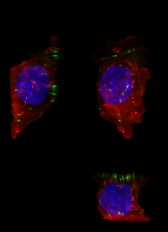

In [21]:
proj_path = Path(dp.csv_data[dp.csv_data["CellId"] == MY_CELL_ID]["save_reg_path_flat_proj"].item())
Image.open(proj_path)

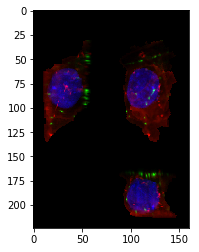

In [22]:
# grab metadata
cell_metadata = dp.csv_data[dp.csv_data.CellId == MY_CELL_ID].drop(columns=["level_0", "Unnamed: 0", "index"])

# search for which split this id is in
splits = {k for k,v in dp.data.items() if MY_CELL_ID in v["CellId"]}
assert len(splits) == 1
split = splits.pop()

# find the index in the split
index_in_split = np.where(dp.data[split]["CellId"] == MY_CELL_ID)[0]
assert len(index_in_split) == 1
index_in_split = index_in_split[0]

# grab the sampled image
gfp_img, struct_ind, ref_img = dp.get_sample(train_or_test=split, inds=[index_in_split])

# make the one-hot encoding
label_onehot = utils.index_to_onehot(struct_ind, len(u_classes)).cuda()

# move ref image to gpu
ref = ref_img.cuda()

# plot
rgb_img = torch.stack([ref_img[:,0,...], gfp_img[:,0,...], ref_img[:,1,...]], dim=1)
plt.imshow(
    tensor2im(
        rgb_img,
        color_transform = np.array(
            [
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ]
        ).T
    ),
);

## loop over structs to generate and save images

In [23]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# TODO: loop over cellid

In [26]:
BATCH_SIZE=2

image_dir = Path(RESULTS_DIR) / "images"
image_dir.mkdir(parents=True, exist_ok=True)

df = pd.DataFrame()

corr_pair_inds = ["i", "j"]

with tqdm(total=N_PAIRS_PER_STRUCTURE*len(STRUCTURES_TO_GEN*len(corr_pair_inds))) as pbar:
    for structure, struct_ind in zip(STRUCTURES_TO_GEN, structure_to_gen_ids):

        pbar.set_description(f"Processing {structure}")
        
        df_tmp = cell_metadata[["CellId"]].copy()
        
        for ij in corr_pair_inds:
            df_tmp[f"GeneratedStructureName_{ij}"] = structure
            df_tmp[f"GeneratedStructureInstance_{ij}"] = -1
            df_tmp[f"GeneratedStructuePath_{ij}"] = ""
        df_tmp = pd.concat([df_tmp]*N_PAIRS_PER_STRUCTURE).reset_index(drop=True)

        for batch in chunks(range(N_PAIRS_PER_STRUCTURE), BATCH_SIZE):

            # one hot structure labels to generate,same for whole batch
            labels_gen_batch = utils.index_to_onehot(struct_ind, len(u_classes)).repeat(len(batch),1).cuda()

            # repeat reference structure over batch
            ref_batch = ref.repeat([len(batch), 1, 1, 1, 1])

            # we want two images per row, image i and image j, so no hidden corr in aggreagate metrics
            for ij in corr_pair_inds:
                
                # generate our gfp samples
                target_gen_batch, _ = ae(target=None, ref=ref_batch, labels=labels_gen_batch)

                # save images
                for b,im_tensor in zip(batch,target_gen_batch):
                    struct_safe_name = structure.replace(" ", "_").lower()
                    img_path = image_dir / f"generated_gfp_image_struct_{struct_safe_name}_instance_{b}_{ij}.ome.tiff"
                    im_write(im_tensor, img_path)

                    df_tmp.at[b, f"GeneratedStructureInstance_{ij}"] = b
                    df_tmp.at[b, f"GeneratedStructuePath_{ij}"] = img_path

                    pbar.update(1)

        df = df.append(df_tmp)

    # merge df with metadata for cell
    df = df.reset_index(drop=True)
    df_out = cell_metadata.merge(df)
    
# save df
df_out.to_csv(Path(RESULTS_DIR) / "generated_structures.csv", index=False)
df_out.shape

Processing Tight junctions: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]     


(12, 84)

In [62]:
torch.tensor(sample_img_i.data[0]).shape

torch.Size([1, 1, 64, 160, 96])

Mitochondria
CellId 109017
sample instance 0


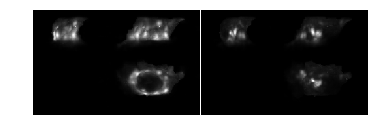

In [59]:
from aicsimageio import AICSImage

sample_row = df_out.sample(1)

sample_img_i = AICSImage(sample_row.GeneratedStructuePath_i.item())
sample_img_j = AICSImage(sample_row.GeneratedStructuePath_j.item())

img_2d_i = tensor2im(torch.tensor(sample_img_i.data[0]))
img_2d_j = tensor2im(torch.tensor(sample_img_j.data[0]))

print(sample_row.GeneratedStructureName_i.item())
print(f"CellId {sample_row.CellId.item()}")
print(f"sample instance {sample_row.GeneratedStructureInstance_i.item()}")

plt.imshow(
    np.concatenate(
        [
            img_2d_i,
            np.ones([img_2d_i.shape[0],1,img_2d_i.shape[2]]),
            img_2d_j,
        ],
        axis=1)
)
plt.axis('off');

In [63]:
df_gen = pd.read_csv(Path(RESULTS_DIR)/ "generated_structures.csv")
df_gen.shape

(4608, 85)

In [64]:
Path(RESULTS_DIR)/ "generated_structures.csv"

PosixPath('/allen/aics/modeling/rorydm/results/multiscale_structure_similarity/generated_gfp_images/generated_structures.csv')

In [65]:
df_gen.GeneratedStructuePath_i.sample().item()

'/allen/aics/modeling/rorydm/results/multiscale_structure_similarity/generated_gfp_images/images/generated_gfp_image_struct_adherens_junctions_instance_190_i.ome.tiff'

In [66]:
df_corr = pd.read_csv(
    "/home/rorydm/projects/cvapipe/local_staging/multiresstructcompare/pairwise_metrics/multires_pairwise_similarity.csv"
)
df_corr.GeneratedStructureName_i.unique()

array(['Actin filaments', 'Actomyosin bundles', 'Adherens junctions',
       'Desmosomes', 'Endoplasmic reticulum', 'Endosomes',
       'Gap junctions', 'Golgi', 'Lysosome', 'Matrix adhesions',
       'Microtubules', 'Mitochondria', 'Nuclear envelope',
       'Nucleolus (Dense Fibrillar Component)',
       'Nucleolus (Granular Component)', 'Peroxisomes', 'Plasma membrane',
       'Tight junctions'], dtype=object)

In [110]:
df_map = dp.csv_data.dropna(subset=["StructureDisplayName"])
df_map = df_map[~df_map["StructureDisplayName"].str.contains("Control")]
dict_map = dict(df_map[["Gene", "StructureDisplayName"]].drop_duplicates().values)

In [111]:
dict_map

{'LAMP1': 'Lysosome',
 'TOMM20': 'Mitochondria',
 'TUBA1B': 'Microtubules',
 'ACTN1': 'Actin filaments',
 'ACTB': 'Actin filaments',
 'CTNNB1': 'Adherens junctions',
 'GJA1': 'Gap junctions',
 'DSP': 'Desmosomes',
 'FBL': 'Nucleolus (Dense Fibrillar Component)',
 'LMNB1': 'Nuclear envelope',
 'SEC61B': 'Endoplasmic reticulum',
 'ST6GAL1': 'Golgi',
 'TJP1': 'Tight junctions',
 'AAVS1': 'Plasma membrane',
 'PXN': 'Matrix adhesions',
 'SLC25A17': 'Peroxisomes',
 'RAB5A': 'Endosomes',
 'MYH10': 'Actomyosin bundles',
 'NPM1': 'Nucleolus (Granular Component)'}